# Multinomial Logistic Regression trained with Pytorch

Implement a multinomial logistic regression model for the classification of the 10 classes in the set [Fashion MNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist).

Multinomial Logistic Regression trained with PyTorch is a machine learning technique used for classification tasks where there are more than two classes. It's an extension of binary logistic regression, allowing for multiple classes to be predicted. A model utilizing multinomial logistic regression trained with PyTorch offers robust classification across multiple categories. It excels in handling complex datasets, leveraging PyTorch's efficiency for effective training and optimization.

## Install packages

In [1]:
!pip install torch-summary

## Importing the required packages

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns

from typing import Tuple, Union
from torchvision import datasets, transforms
from torchsummary import summary
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.1.1  Device: cuda


## Dataset preparation: Dataset class

In [3]:
class MNISTDataset(Dataset):
    def __init__(self, path_csv: str):
        """
        Constructor for the MNISTDataset class.

        Loads data from a CSV file, processing it for use in a machine learning model.
        Each row in the CSV file represents an MNIST image, where the first column is the label, and the rest 
        of the columns represent the image pixels.

        :param path_csv: The path to the CSV file containing the MNIST data.
        """
        super(MNISTDataset, self).__init__()
        assert os.path.exists(path_csv) and os.path.isfile(path_csv), f'Path {path_csv} does not point to a file'

        # Load the data, excluding the header if it exists
        _all_digits: np.ndarray = pd.read_csv(path_csv, header=0, dtype=float).values

        _y: np.ndarray = _all_digits[:, 0]  # labels
        _x: np.ndarray = _all_digits[:, 1:] / 255  # input values scaled to 0..1

        self.x: torch.Tensor = torch.Tensor(_x)  # convert to PyTorch tensors
        self.y: torch.Tensor = torch.Tensor(_y)

    def __len__(self) -> int:
        """
        Returns the number of examples in the dataset.

        :return: Length of the dataset.
        """
        return len(self.y)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns a data example and its associated label, indexed by the 'index' parameter.

        :param index: The index of the desired example.
        :return: A tuple (data, label), where 'data' is a tensor of pixels, and 'label' is a tensor with the label.
        """
        return self.x[index, :], self.y[index]

# Dataset instances creation
train_ds = MNISTDataset('../data/fashion-mnist_train.csv')
test_ds = MNISTDataset('../data/fashion-mnist_test.csv')

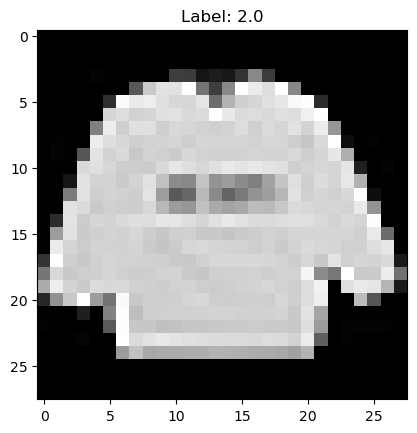

In [4]:
# Displaying the first image from the training set
plt.imshow(train_ds.x[0].reshape(28, 28), cmap='gray')
plt.title(f"Label: {train_ds.y[0].item()}")
plt.show()

## Loading data using a DataLoader

In [5]:
# Setting the minibatch size
batch_size: int = 32  # This is adjustable depending on the available memory on GPU

# Creating DataLoaders for the datasets
train_loader: DataLoader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader: DataLoader = DataLoader(test_ds, batch_size=batch_size)

# Iterating through DataLoader to check tensor shapes
for data, label in train_loader:
    # Checking the shapes of data and labels tensors
    print(data.shape, label.shape)  # Printing the shapes of tensors: data (batch_size x 784), labels (batch_size)
    break  # Exiting the loop after the first iteration

torch.Size([32, 784]) torch.Size([32])


## Model definition

In [6]:
class MultinomialLogisticRegression(nn.Module):
    def __init__(self, input_size: int = 784, num_classes: int = 10) -> None:
        """
        Initializes a MultinomialLogisticRegression object.

        :param input_size: The size of an input vector, e.g., for MNIST it is 784.
        :param num_classes: The number of classes for multinomial classification.
        """
        super(MultinomialLogisticRegression, self).__init__()
        self.input_size: int = input_size
        self.fully_connected: nn.Linear = nn.Linear(input_size, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Propagates the inputs (x) through the model.

        :param x: A minibatch of examples of shape [batch_size, input_size].
        :return: Class scores before applying softmax, of shape [batch_size, num_classes].
        """
        # Propagating the input through the fully connected layer
        x = self.fully_connected(x)
        return x

# Using the class for multinomial classification
model: MultinomialLogisticRegression = MultinomialLogisticRegression()

Print the model:

In [7]:
print(model)

MultinomialLogisticRegression(
  (fully_connected): Linear(in_features=784, out_features=10, bias=True)
)


More details can be found with the `summary()` function:

In [8]:
summary(model);

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0


We pass the model to the device. If device=cpu, then the line below has no effect. If device=cuda, then the model is passed to the GPU and the run will be faster:

In [9]:
print(f'device={device}')
model.to(device)

device=cuda


MultinomialLogisticRegression(
  (fully_connected): Linear(in_features=784, out_features=10, bias=True)
)

## Model Training

We will have several training epochs. In each era:
* all the minibatches of data in train_loader are traversed
* the minibatch error function is calculated, the gradients are calculated, the gradients are applied to change the weights
* at the end of each epoch, the model is run on the test set, to see the accuracy obtained

In [10]:
def test_multinomial(model: nn.Module, loader: DataLoader, device: torch.device) -> float:
    """
    Tests the multinomial model on the data provided by the loader.
    :param model: multinomial classification model
    :param loader: a DataLoader providing the data from the test set
    :param device: the device on which the model is located (CPU, GPU, TPU, etc.)
    :return: prediction accuracy
    """
    correctly_classified: int = 0
    total_items: int = 0
    model.eval()  # Prepares the model for evaluation

    with torch.no_grad():  # Disables gradient computation
        for x, y in loader:
            x, y = x.to(device), y.to(device)  # Moves the data to the specified device
            y_hat: torch.Tensor = model(x)  # Gets the model predictions

            # Prediction is the class with maximum probability
            results = torch.max(y_hat, dim=1)
            predicted_class: torch.Tensor = results[1]

            correctly_classified += torch.sum(predicted_class == y)
            total_items += y.size(0)

    accuracy: float = (correctly_classified / total_items).cpu().detach().item()  # Calculates accuracy
    return accuracy

The accuracy of the untrained model on the test set is:

In [11]:
acc: float = test_multinomial(model, test_loader, device)
print(f'Accuracy of the untrained model: {acc * 100}%')

Accuracy of the untrained model: 8.069999516010284%


Optimizer instance. We use a Stochastic Gradient Descent algorithm, with weight decay (equivalent to L2 regularization):

In [12]:
optimizer: torch.optim.Optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-3)

The error function `loss_fn` is `torch.nn.CrossEntropyLoss`

In [13]:
loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss()

In [14]:
# the number of epochs
epochs:int = 30

In [15]:
losses: list[float] = []
accuracies: list[float] = []

for epoch in range(epochs):
    model.train()
    epoch_loss: float = 0
    total_items: int = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device).long()

        optimizer.zero_grad()

        y_hat: torch.Tensor = model(x)
        loss: torch.Tensor = loss_fn(y_hat, y)
        epoch_loss += loss.item() * len(x)
        total_items += len(x)

        loss.backward()
        optimizer.step()

    epoch_loss /= total_items
    losses.append(epoch_loss)
    print(f'Epoch: {epoch+1}/{epochs}: loss = {epoch_loss:.7f}')

    acc_test: float = test_multinomial(model, test_loader, device)
    accuracies.append(acc_test)
    print(f'Epoch: {epoch + 1}/{epochs}: accuracy on test set = {acc_test * 100:.4f}%\n')

Epoch: 1/30: loss = 0.8209449
Epoch: 1/30: accuracy on test set = 79.4900%

Epoch: 2/30: loss = 0.5938388
Epoch: 2/30: accuracy on test set = 81.7200%

Epoch: 3/30: loss = 0.5464299
Epoch: 3/30: accuracy on test set = 82.3500%

Epoch: 4/30: loss = 0.5214933
Epoch: 4/30: accuracy on test set = 83.1600%

Epoch: 5/30: loss = 0.5052988
Epoch: 5/30: accuracy on test set = 83.6300%

Epoch: 6/30: loss = 0.4931300
Epoch: 6/30: accuracy on test set = 83.8700%

Epoch: 7/30: loss = 0.4841081
Epoch: 7/30: accuracy on test set = 84.1500%

Epoch: 8/30: loss = 0.4773259
Epoch: 8/30: accuracy on test set = 84.0800%

Epoch: 9/30: loss = 0.4714039
Epoch: 9/30: accuracy on test set = 84.5500%

Epoch: 10/30: loss = 0.4665674
Epoch: 10/30: accuracy on test set = 84.4900%

Epoch: 11/30: loss = 0.4621190
Epoch: 11/30: accuracy on test set = 84.6500%

Epoch: 12/30: loss = 0.4587432
Epoch: 12/30: accuracy on test set = 84.5200%

Epoch: 13/30: loss = 0.4553675
Epoch: 13/30: accuracy on test set = 84.9700%

Epoc

## Multinomial Logistic Regression evolution graphs

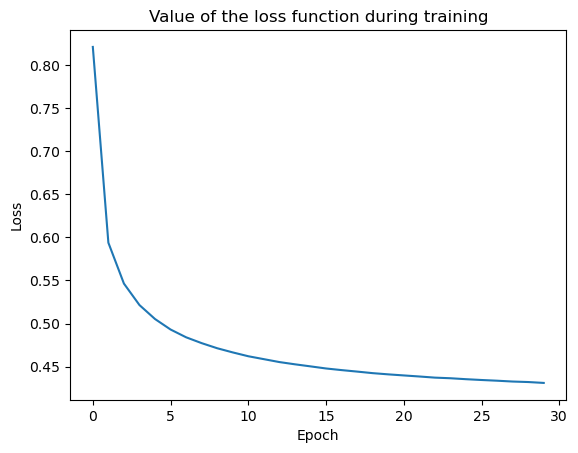

In [16]:
# Allows disabling OpenMP library warnings
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Value of the loss function during training')
plt.show()

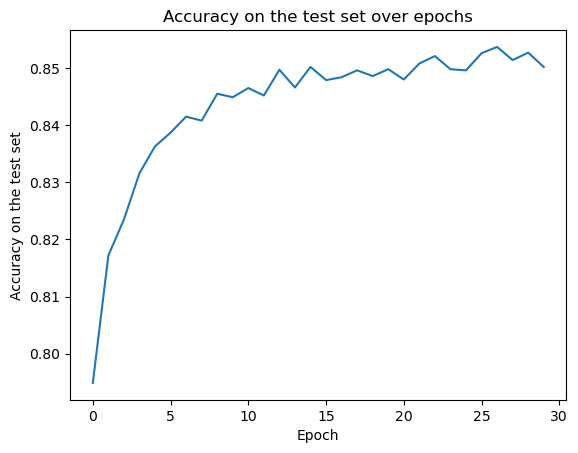

In [17]:
plt.plot(accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy on the test set')
plt.title('Accuracy on the test set over epochs')
plt.show()

## Confusion Matrix

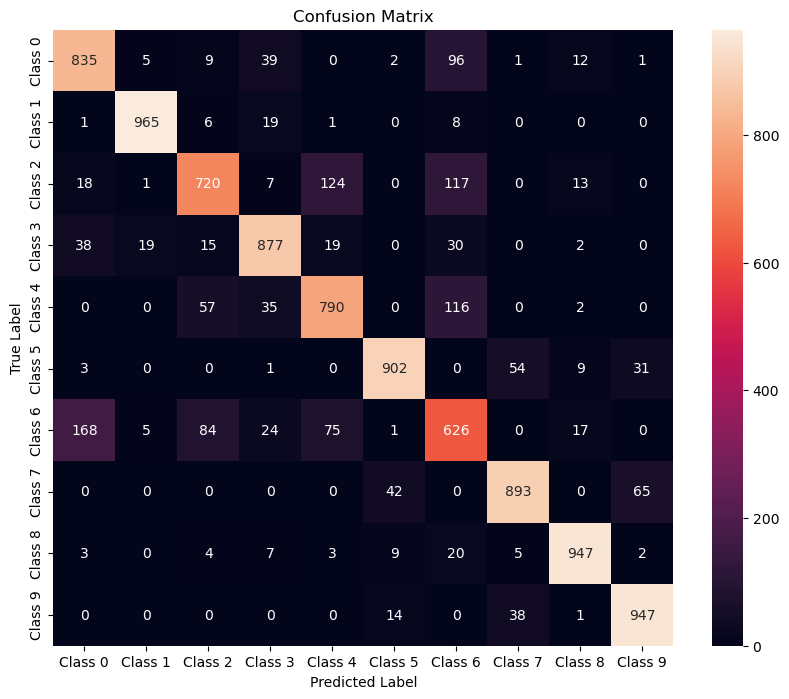

In [18]:
def get_predictions(model: nn.Module, dataloader: DataLoader) -> Tuple[np.ndarray, np.ndarray]:
    """
    Get the model predictions for a given dataloader.

    :param model: The classification model.
    :param dataloader: The DataLoader where data is fetched from.
    :return: A tuple containing the predictions and the true labels.
    """
    all_predictions: list[int] = []
    true_labels: list[int] = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return np.array(all_predictions), np.array(true_labels)

# Get predictions and true labels for the test set
predictions, true_labels = get_predictions(model, test_loader)

# Calculate the confusion matrix
conf_matrix: np.ndarray = confusion_matrix(true_labels, predictions)

# Define labels for the confusion matrix
labels = [f"Class {i}" for i in range(conf_matrix.shape[0])]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Adam Optimizer

In [19]:
optimizer: torch.optim.Optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
losses: list[float] = []
accuracies: list[float] = []

for epoch in range(epochs):
    model.train()
    epoch_loss: float = 0
    total_items: int = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device).long()

        optimizer.zero_grad()

        y_hat: torch.Tensor = model(x)
        loss: torch.Tensor = loss_fn(y_hat, y)
        epoch_loss += loss.item() * len(x)
        total_items += len(x)

        loss.backward()
        optimizer.step()

    epoch_loss /= total_items
    losses.append(epoch_loss)
    print(f'Epoch: {epoch+1}/{epochs}: loss = {epoch_loss:.7f}')

    acc_test: float = test_multinomial(model, test_loader, device)
    accuracies.append(acc_test)
    print(f'Epoch: {epoch + 1}/{epochs}: accuracy on test set = {acc_test * 100:.4f}%\n')

Epoch: 1/30: loss = 0.4332530
Epoch: 1/30: accuracy on test set = 85.1800%

Epoch: 2/30: loss = 0.4200469
Epoch: 2/30: accuracy on test set = 85.4900%

Epoch: 3/30: loss = 0.4123050
Epoch: 3/30: accuracy on test set = 85.5600%

Epoch: 4/30: loss = 0.4059574
Epoch: 4/30: accuracy on test set = 85.4500%

Epoch: 5/30: loss = 0.4025106
Epoch: 5/30: accuracy on test set = 85.5100%

Epoch: 6/30: loss = 0.3980423
Epoch: 6/30: accuracy on test set = 85.3700%

Epoch: 7/30: loss = 0.3953250
Epoch: 7/30: accuracy on test set = 85.7600%

Epoch: 8/30: loss = 0.3930739
Epoch: 8/30: accuracy on test set = 86.0600%

Epoch: 9/30: loss = 0.3909474
Epoch: 9/30: accuracy on test set = 85.9400%

Epoch: 10/30: loss = 0.3899404
Epoch: 10/30: accuracy on test set = 85.4900%

Epoch: 11/30: loss = 0.3873267
Epoch: 11/30: accuracy on test set = 85.6100%

Epoch: 12/30: loss = 0.3856372
Epoch: 12/30: accuracy on test set = 84.4200%

Epoch: 13/30: loss = 0.3843289
Epoch: 13/30: accuracy on test set = 85.0600%

Epoc

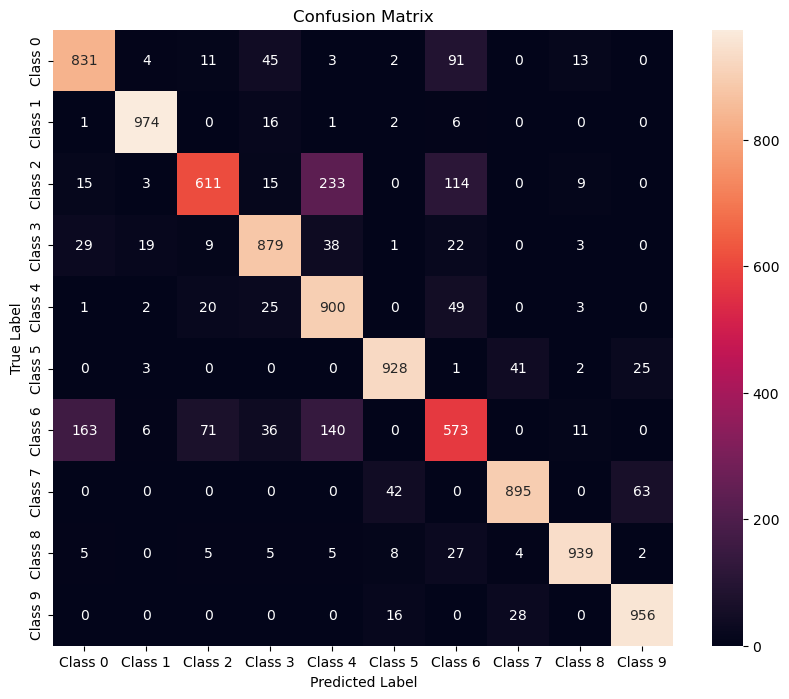

In [21]:
# Get predictions and true labels for the test set
predictions, true_labels = get_predictions(model, test_loader)

# Calculate the confusion matrix
conf_matrix: np.ndarray = confusion_matrix(true_labels, predictions)

# Define labels for the confusion matrix
labels = [f"Class {i}" for i in range(conf_matrix.shape[0])]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

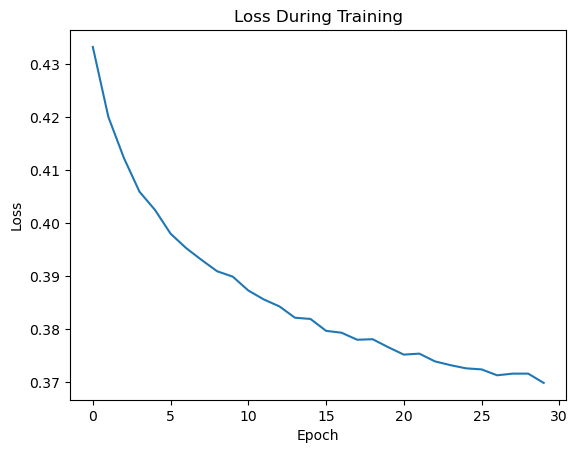

In [22]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss During Training')
plt.show()

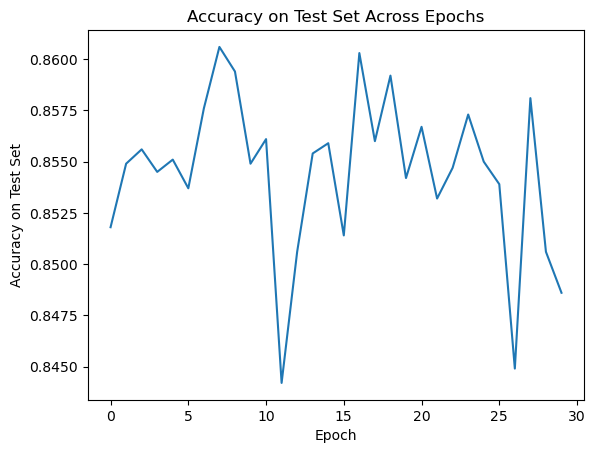

In [23]:
plt.plot(accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy on Test Set')
plt.title('Accuracy on Test Set Across Epochs')
plt.show()

The loss on the training set and on the test is presented graphically below. In another graph, the accuracy on the training set and on the test set.

In [24]:
def compute_loss(model: nn.Module, loader: DataLoader, device: torch.device, loss_fn: nn.Module) -> float:
    """
    Computes the average loss on a dataset using the specified model and loss function.

    :param model: The neural network model.
    :param loader: The DataLoader providing the data.
    :param device: The device on which the computation is performed (e.g., 'cuda', 'cpu').
    :param loss_fn: The loss calculation function.
    :return: The average loss computed over the entire provided dataset.
    """
    total_loss: float = 0.0
    total_items: int = 0

    model.eval()  # Sets the model in evaluation mode
    with torch.no_grad():  # Disables gradient computation
        for x, y in loader:
            x, y = x.to(device), y.to(device).long()  # Move data to device and convert labels to long type
            y_hat: torch.Tensor = model(x)
            loss: torch.Tensor = loss_fn(y_hat, y.long())
            total_loss += loss.item() * x.size(0)
            total_items += x.size(0)

    return total_loss / total_items

In [25]:
train_losses: list[float] = []
test_losses: list[float] = []
train_accuracies: list[float] = []
test_accuracies: list[float] = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss: float = 0
    total_train_items: int = 0

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device).long()

        optimizer.zero_grad()

        y_train_pred: torch.Tensor = model(x_train)
        train_loss: torch.Tensor = loss_fn(y_train_pred, y_train)
        epoch_train_loss += train_loss.item() * len(x_train)
        total_train_items += len(x_train)

        train_loss.backward()
        optimizer.step()

    train_loss_avg: float = epoch_train_loss / total_train_items
    train_losses.append(train_loss_avg)

    train_accuracy: float = test_multinomial(model, train_loader, device)
    train_accuracies.append(train_accuracy)

    test_loss_avg: float = compute_loss(model, test_loader, device, loss_fn)
    test_losses.append(test_loss_avg)

    test_accuracy: float = test_multinomial(model, test_loader, device)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch + 1}/{epochs}:')
    print(f'   Training Loss: {train_loss_avg:.4f}')
    print(f'   Training Accuracy: {train_accuracy * 100:.4f}%')
    print(f'   Test Loss: {test_loss_avg:.4f}')
    print(f'   Test Accuracy: {test_accuracy * 100:.4f}%\n')

Epoch 1/30:
   Training Loss: 0.3695
   Training Accuracy: 87.1933%
   Test Loss: 0.4322
   Test Accuracy: 85.4800%

Epoch 2/30:
   Training Loss: 0.3691
   Training Accuracy: 87.6233%
   Test Loss: 0.4221
   Test Accuracy: 85.8200%

Epoch 3/30:
   Training Loss: 0.3684
   Training Accuracy: 87.6067%
   Test Loss: 0.4245
   Test Accuracy: 85.7700%

Epoch 4/30:
   Training Loss: 0.3670
   Training Accuracy: 87.0633%
   Test Loss: 0.4371
   Test Accuracy: 85.1700%

Epoch 5/30:
   Training Loss: 0.3677
   Training Accuracy: 86.9550%
   Test Loss: 0.4397
   Test Accuracy: 85.0400%

Epoch 6/30:
   Training Loss: 0.3674
   Training Accuracy: 87.4783%
   Test Loss: 0.4273
   Test Accuracy: 85.7100%

Epoch 7/30:
   Training Loss: 0.3665
   Training Accuracy: 87.0067%
   Test Loss: 0.4379
   Test Accuracy: 85.1700%

Epoch 8/30:
   Training Loss: 0.3654
   Training Accuracy: 87.2750%
   Test Loss: 0.4359
   Test Accuracy: 85.2300%

Epoch 9/30:
   Training Loss: 0.3652
   Training Accuracy: 87.19

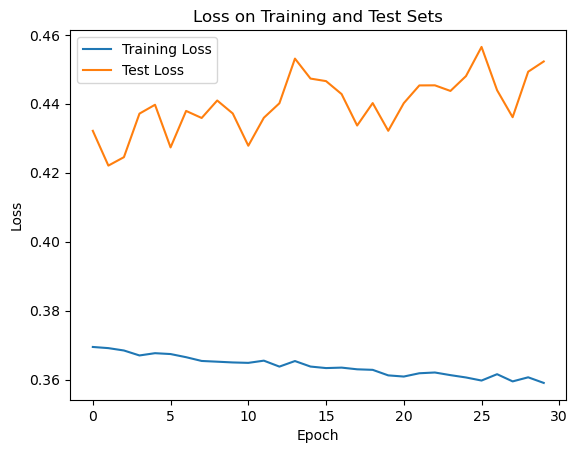

In [26]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss on Training and Test Sets')
plt.legend()
plt.show()

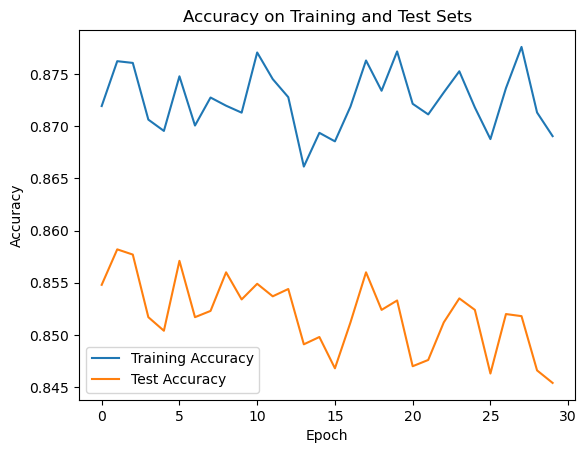

In [27]:
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy on Training and Test Sets')
plt.legend()
plt.show()